# FIT5196 Assessment 4

#### Group number: 17
#### Student Names: Roopesh Kumar Ramesh, Nikita Mary John
#### Student ID: 30344565, 30142776

Date: 27/10/2019

Version: 1.0

Environment: Python 3 and Jupyter notebook

Libraries used: 
* pandas (for dataframe, included in Anaconda Python 3) 
* re (for regular expressions, included in Anaconda Python 3) 
* geopandas (to read shapefiles)
* shapely.geometry (to find if point in polygon)
* math (for mathematical calculations, included in Anaconda Python 3)
* urllib.request (to open urls)
* bs4 (parsing html)
* numpy (included in Anaconda Python 3)
* matplotlib (for visualizations)
* sklearn (for normalization and transformation)

## Introduction

The aim of this assignment is to create a dataset by concatenating data from various sources, such as text files, xml files, excel files, websites etc. After the data has been colated, we are required to observe various transformation and normalization techniques and their effect on the data. 

The given csv file contains information about properties and their features. In the csv file provided to us, there are a total of 680 unique property entries. 

NOTE: In order for the following code to run, the input text file and all the other files read must be stored in the same folder as this file.

## 1.  Import libraries 

In [1]:
import pandas as pd
import re
import geopandas
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import math
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing

## 2. Data Integration

First, we opened the csv file and stored its contents as a dataframe called initial_dataset. 

In [2]:
initial_dataset= pd.read_csv('Group017.csv') #reading the csv file

In [3]:
initial_dataset.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID275585343,15 Kwinana Ct,3,h,1223500.0,22/08/2016,2.0,2.0,721.0,39.0,-37.75800,145.04080
1,ID702339222,12A Almond St,2,h,997000.0,29/04/2017,1.0,2.0,311.0,94.0,-37.88950,145.02290
2,ID784956327,4/16 Hotham Gr,2,u,660000.0,12/11/2016,1.0,0.0,477.0,49.0,-37.88040,144.99690
3,ID219098083,48 Sydney St,3,h,840000.0,27/11/2016,1.0,0.0,697.0,99.0,-37.78090,144.82280
4,ID292446805,16 Hodgson St,5,h,3450000.0,26/08/2017,2.0,2.0,668.0,13.0,-37.80795,145.01474


We realised that there were a number of duplicate rows in the dataframe. We thus removed these duplicate values.

In [4]:
initial_dataset=initial_dataset.drop_duplicates(subset=None, keep='first', inplace=False) #dropping duplicate rows
initial_dataset.reset_index(inplace=True)
initial_dataset = initial_dataset.drop('index', axis=1)

In [5]:
initial_dataset.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID275585343,15 Kwinana Ct,3,h,1223500.0,22/08/2016,2.0,2.0,721.0,39.0,-37.75800,145.04080
1,ID702339222,12A Almond St,2,h,997000.0,29/04/2017,1.0,2.0,311.0,94.0,-37.88950,145.02290
2,ID784956327,4/16 Hotham Gr,2,u,660000.0,12/11/2016,1.0,0.0,477.0,49.0,-37.88040,144.99690
3,ID219098083,48 Sydney St,3,h,840000.0,27/11/2016,1.0,0.0,697.0,99.0,-37.78090,144.82280
4,ID292446805,16 Hodgson St,5,h,3450000.0,26/08/2017,2.0,2.0,668.0,13.0,-37.80795,145.01474


Our dataset now has 680 unique entries.

In [6]:
initial_dataset['ID'].nunique()

680

### i) Suburb

In order to find the suburb of each property, we can use the vic_suburb_boundary file provided to us. This file contains shape files, therefore we use geopandas to read it. We then get a datatframe which we named geo_dataset. In this dataframe, two columns are important to us- geometry and VIC_LOCA_2

In [7]:
geo_dataset= geopandas.read_file('vic_suburb_boundary') #reading the shape file as a dataframe

In [8]:
geo_dataset.head()

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74552399 -35.07228701, 141.74552..."
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.668767 -37.39571245, 148.6687620..."
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,"POLYGON ((142.92287999 -37.97885997, 142.90449..."
3,6673,2011-08-31,None,VIC734,2017-08-09,None,DEPTFORD,None,None,G,None,2,"POLYGON ((147.82335712 -37.66000897, 147.82312..."
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,None,None,G,None,2,"POLYGON ((141.279783 -35.99858911, 141.2798853..."


We use the geometry column- which consists of polygons in order to determine the suburb. If the polygon containts the co-ordinates of the property, we return the corresponding suburb name.

In [9]:
suburb=[]
lon=initial_dataset['Longtitude']
lat=initial_dataset['Lattitude']
for i in range(len(lon)):
    item=Point(lon[i], lat[i])
    suburb.append((geo_dataset[geo_dataset['geometry'].contains(item)].VIC_LOCA_2).to_string()) #checking if polygon contains point, if yes, suburb is returned in list

In [10]:
for i in range(len(suburb)):
    if suburb[i] is None:
        suburb[i]="not available"
    else:
        suburb[i]=re.sub(r'\d', '', suburb[i]).strip()

We now have a list of the corresponding suburbs to the properties. We next add this to the dataset.

In [11]:
initial_dataset['Suburb']=suburb #suburb list added to dataframe

In [12]:
initial_dataset.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb
0,ID275585343,15 Kwinana Ct,3,h,1223500.0,22/08/2016,2.0,2.0,721.0,39.0,-37.75800,145.04080,IVANHOE
1,ID702339222,12A Almond St,2,h,997000.0,29/04/2017,1.0,2.0,311.0,94.0,-37.88950,145.02290,CAULFIELD SOUTH
2,ID784956327,4/16 Hotham Gr,2,u,660000.0,12/11/2016,1.0,0.0,477.0,49.0,-37.88040,144.99690,RIPPONLEA
3,ID219098083,48 Sydney St,3,h,840000.0,27/11/2016,1.0,0.0,697.0,99.0,-37.78090,144.82280,ALBION
4,ID292446805,16 Hodgson St,5,h,3450000.0,26/08/2017,2.0,2.0,668.0,13.0,-37.80795,145.01474,KEW


Now, suburb has been added to the dataset.

We reordered and renamed the columns as follows:

In [13]:
initial_dataset.columns

Index(['ID', 'Address', 'Rooms', 'Type', 'Price', 'Date', 'Bathroom', 'Car',
       'Landsize', 'Age', 'Lattitude', 'Longtitude', 'Suburb'],
      dtype='object')

In [14]:
initial_dataset = initial_dataset[['ID', 'Address', 'Suburb', 'Price', 'Type', 'Date', 'Rooms', 'Bathroom', 'Car', 'Landsize', 'Age', 'Lattitude', 'Longtitude']]
initial_dataset.rename(columns={'Lattitude':'Latitude', 'Landsize':'LandSize'}, inplace=True)

In [15]:
initial_dataset.head()

,ID,Address,Suburb,Price,Type,Date,Rooms,Bathroom,Car,LandSize,Age,Latitude,Longtitude
0,ID275585343,15 Kwinana Ct,IVANHOE,1223500.0,h,22/08/2016,3,2.0,2.0,721.0,39.0,-37.75800,145.04080
1,ID702339222,12A Almond St,CAULFIELD SOUTH,997000.0,h,29/04/2017,2,1.0,2.0,311.0,94.0,-37.88950,145.02290
2,ID784956327,4/16 Hotham Gr,RIPPONLEA,660000.0,u,12/11/2016,2,1.0,0.0,477.0,49.0,-37.88040,144.99690
3,ID219098083,48 Sydney St,ALBION,840000.0,h,27/11/2016,3,1.0,0.0,697.0,99.0,-37.78090,144.82280
4,ID292446805,16 Hodgson St,KEW,3450000.0,h,26/08/2017,5,2.0,2.0,668.0,13.0,-37.80795,145.01474


### ii) Train Data

We use the gtfs files provided in order to get data on trains and stations. In the gtfs folder, file 1 refers to regional trains while 2 refers to metropolitan trains. We only look into these two files and their contents for this portion of the assignment.

We first start with regional train stations and lines

In [16]:
regional_stops=pd.read_csv('gtfs/1/google_transit/stops.txt',sep = ',') #reading csv file

In [17]:
regional_stops.head()

,stop_id,stop_name,stop_lat,stop_lon
0,17204,Wallan Railway Station (Wallan),-37.416861,145.005372
1,19980,Melton Railway Station (Melton South),-37.703293,144.572524
2,19981,Rockbank Railway Station (Rockbank),-37.729261,144.650631
3,19982,Deer Park Railway Station (Deer Park),-37.777764,144.772304
4,19998,Sunbury Railway Station (Sunbury),-37.579206,144.728165


In [18]:
regional_stops[regional_stops['stop_name']=="Southern Cross Railway Station (Melbourne City)"] #finding stop_id of southern cross

,stop_id,stop_name,stop_lat,stop_lon
7,20043,Southern Cross Railway Station (Melbourne City),-37.818334,144.952525


Thus the stop_id of southern cross when it comes to regional is 20043.
We need to find routes that travel direct to southern cross every day of the week between 7 and 9:30 am.
We start by using the regional calendar file to see all the services that operate on all days of the week.

In [19]:
regional_cal=pd.read_csv('gtfs/1/google_transit/calendar.txt',sep = ',')
regional_cal.head()

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,UR,0,0,0,1,0,0,0,20190509,20190509
1,T6,0,0,0,0,1,0,0,20190510,20190510
2,T2,0,0,0,0,0,1,0,20190511,20190511
3,UJ,0,0,0,0,0,0,1,20190512,20190512
4,UO,1,0,0,0,0,0,0,20190513,20190513


In [20]:
services=regional_cal['service_id'][(regional_cal['monday']==1) & (regional_cal['tuesday']==1) & (regional_cal['wednesday']==1) & (regional_cal['thursday']==1) & (regional_cal['friday']==1)].tolist() #filtering service_id with service on all weekdays

In [21]:
regional_trips=pd.read_csv('gtfs/1/google_transit/trips.txt',sep = ',')

We then filter and fild all the trip_ids of the trains on the above obtained services.

In [22]:
trip_ids=regional_trips['trip_id'][regional_trips['service_id'].isin(services)].tolist() #getting trip_ids of services found above

In [23]:
len(trip_ids)

1404

In [24]:
regional_stoptimes=pd.read_csv('gtfs/1/google_transit/stop_times.txt',sep = ',')

Next, we filter out lines that depart between 7am and 9:30 am.

In [25]:
regional_stoptimes=regional_stoptimes[(regional_stoptimes['departure_time']<="09:30:00") & (regional_stoptimes['departure_time']>="07:00:00")]

In [26]:
regional_stoptimes.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
3,7548.UR.1-V08-A-mjp-1.1.H,07:16:00,07:16:00,20339,4,NaN,0,0,94514.728171
4,7548.UR.1-V08-A-mjp-1.1.H,07:32:00,07:34:00,20351,5,NaN,0,0,116895.210301
5,7548.UR.1-V08-A-mjp-1.1.H,07:45:00,07:45:00,20330,6,NaN,0,0,130530.089787
6,7548.UR.1-V08-A-mjp-1.1.H,07:57:00,07:57:00,20328,7,NaN,0,0,145000.117101
7,7548.UR.1-V08-A-mjp-1.1.H,08:16:00,08:16:00,20357,10,NaN,0,0,175519.536474


In [27]:
newdf=regional_stoptimes[(regional_stoptimes['trip_id'].isin(trip_ids))]

In [28]:
newdf.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
581,1051.T0.1-V08-G-mjp-1.1.H,07:16:00,07:16:00,20339,4,NaN,0,0,94514.728171
582,1051.T0.1-V08-G-mjp-1.1.H,07:32:00,07:34:00,20351,5,NaN,0,0,116895.210301
583,1051.T0.1-V08-G-mjp-1.1.H,07:45:00,07:45:00,20330,6,NaN,0,0,130530.089787
584,1051.T0.1-V08-G-mjp-1.1.H,07:57:00,07:57:00,20328,7,NaN,0,0,145000.117101
585,1051.T0.1-V08-G-mjp-1.1.H,08:16:00,08:16:00,20357,10,NaN,0,0,175519.536474


We then find all the lines that stop at southern cross

In [29]:
newdf=newdf[(newdf['stop_id']==20043)]  #getting all southern cross entries

In [30]:
regional_trains_fin=pd.merge(regional_stoptimes, newdf, on='trip_id')

We then filter for all the trains that have a stop sequence less than that of southern cross, because we want southern cross to be after these stops.

In [31]:
regionaltrains_stopping_SC=regional_trains_fin[regional_trains_fin['stop_sequence_x']<regional_trains_fin['stop_sequence_y']]

In [32]:
regionaltrains_stopping_SC.head()

,trip_id,arrival_time_x,departure_time_x,stop_id_x,stop_sequence_x,stop_headsign_x,pickup_type_x,drop_off_type_x,shape_dist_traveled_x,arrival_time_y,departure_time_y,stop_id_y,stop_sequence_y,stop_headsign_y,pickup_type_y,drop_off_type_y,shape_dist_traveled_y
36,1094.T0.1-V12-G-mjp-1.1.H,07:23:00,07:23:00,20320,1,NaN,0,0,0.000000,08:39:00,08:39:00,20043,15,NaN,0,0,92030.094681
37,1094.T0.1-V12-G-mjp-1.1.H,07:31:00,07:31:00,20361,2,NaN,0,0,13417.188090,08:39:00,08:39:00,20043,15,NaN,0,0,92030.094681
38,1094.T0.1-V12-G-mjp-1.1.H,07:37:00,07:37:00,20325,3,NaN,0,0,22263.268829,08:39:00,08:39:00,20043,15,NaN,0,0,92030.094681
39,1094.T0.1-V12-G-mjp-1.1.H,07:41:00,07:41:00,20315,4,NaN,0,0,27817.107724,08:39:00,08:39:00,20043,15,NaN,0,0,92030.094681
40,1094.T0.1-V12-G-mjp-1.1.H,07:46:00,07:46:00,20337,5,NaN,0,0,35154.789037,08:39:00,08:39:00,20043,15,NaN,0,0,92030.094681


Finally, we get the stop_ids of the above filtered trains and get the unique ones.

In [33]:
regional_stopping_SC=set(regionaltrains_stopping_SC['stop_id_x']) #getting all unique stop_ids

In [34]:
regional_stopping_SC=list(regional_stopping_SC)
len(regional_stopping_SC)

57

Adding a column which shows if the train stops at southern cross or not. 1 if it stops 0 otherwise

In [35]:
stops=[]
temp=regional_stops['stop_id']
for item in temp:
    if item in regional_stopping_SC:
        stops.append(1) #appends 1 if there is a direct trip to southern cross
    else:
        stops.append(0)
regional_stops['Trip_to_SC']=stops #adding this to the stops dataframe

We do the same steps as above for the metropolitan trains as follows:

In [36]:
metro_stops=pd.read_csv('gtfs/2/google_transit/stops.txt',sep = ',')

In [37]:
metro_stops.head()

,stop_id,stop_name,stop_lat,stop_lon
0,15351,Sunbury Railway Station (Sunbury),-37.579091,144.727319
1,15353,Diggers Rest Railway Station (Diggers Rest),-37.627017,144.719922
2,19827,Stony Point Railway Station (Crib Point),-38.374235,145.221837
3,19828,Crib Point Railway Station (Crib Point),-38.366123,145.204043
4,19829,Morradoo Railway Station (Crib Point),-38.354033,145.189602


In [38]:
metro_stops[metro_stops['stop_name']=="Southern Cross Railway Station (Melbourne City)"] #getting the stop_id of southern cross

,stop_id,stop_name,stop_lat,stop_lon
210,22180,Southern Cross Railway Station (Melbourne City),-37.817936,144.951411


We then find all the lines that stop at southern cross

In [39]:
metro_cal=pd.read_csv('gtfs/2/google_transit/calendar.txt',sep = ',')
metro_cal.head()

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,T5,0,0,0,1,0,0,0,20190509,20190509
1,UJ,0,0,0,0,0,0,1,20190510,20190512
2,T2,0,0,0,0,0,1,0,20190510,20190512
3,T6,0,0,0,0,1,0,0,20190510,20190512
4,T5_1,1,1,1,1,0,0,0,20190513,20190516


In [40]:
services=metro_cal['service_id'][(metro_cal['monday']==1) & (metro_cal['tuesday']==1) & (metro_cal['wednesday']==1) & (metro_cal['thursday']==1) & (metro_cal['friday']==1)].tolist() #services that operate on all weekdays

In [41]:
services

['T0']

In [42]:
metro_trips=pd.read_csv('gtfs/2/google_transit/trips.txt',sep = ',')

In [43]:
trip_ids=metro_trips['trip_id'][metro_trips['service_id'].isin(services)].tolist() #trips in the above obtained services

In [44]:
len(trip_ids)

2360

In [45]:
metro_stoptimes=pd.read_csv('gtfs/2/google_transit/stop_times.txt',sep = ',')

In [46]:
metro_stoptimes=metro_stoptimes[(metro_stoptimes['departure_time']<="09:30:00") & (metro_stoptimes['departure_time']>="07:00:00")]

In [47]:
metro_stoptimes.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
7,9125.T5.2-ALM-A-mjp-1.1.H,09:21:00,09:21:00,19853,1,NaN,0,0,0.000000
8,9125.T5.2-ALM-A-mjp-1.1.H,09:24:00,09:24:00,19852,2,NaN,0,0,1506.610171
9,9125.T5.2-ALM-A-mjp-1.1.H,09:25:00,09:25:00,19851,3,NaN,0,0,1992.788001
10,9125.T5.2-ALM-A-mjp-1.1.H,09:27:00,09:27:00,19850,4,NaN,0,0,3020.805604
11,9125.T5.2-ALM-A-mjp-1.1.H,09:28:00,09:28:00,19849,5,NaN,0,0,3968.143881


In [48]:
newdf=metro_stoptimes[(metro_stoptimes['trip_id'].isin(trip_ids))]

In [49]:
newdf.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
10480,8267.T0.2-ALM-F-mjp-1.1.H,09:21:00,09:21:00,19853,1,NaN,0,0,0.000000
10481,8267.T0.2-ALM-F-mjp-1.1.H,09:24:00,09:24:00,19852,2,NaN,0,0,1506.610171
10482,8267.T0.2-ALM-F-mjp-1.1.H,09:25:00,09:25:00,19851,3,NaN,0,0,1992.788001
10483,8267.T0.2-ALM-F-mjp-1.1.H,09:27:00,09:27:00,19850,4,NaN,0,0,3020.805604
10484,8267.T0.2-ALM-F-mjp-1.1.H,09:28:00,09:28:00,19849,5,NaN,0,0,3968.143881


In [50]:
newdf=newdf[(newdf['stop_id']==22180)] #only southern cross entries

In [51]:
metro_trains_fin=pd.merge(metro_stoptimes, newdf, on='trip_id') 

In [52]:
metrotrains_stopping_SC=metro_trains_fin[metro_trains_fin['stop_sequence_x']<metro_trains_fin['stop_sequence_y']] #checking 

In [53]:
metro_stopping_SC=set(metrotrains_stopping_SC['stop_id_x']) #list of unique metropolitan stop_ids that stop at southern cross

In [54]:
metro_stopping_SC=list(metro_stopping_SC)
len(metro_stopping_SC)

197

In [55]:
stops=[]
temp=metro_stops['stop_id']
for item in temp:
    if item in metro_stopping_SC:
        stops.append(1)
    else:
        stops.append(0)
metro_stops['Trip_to_SC']=stops

We finally concatenate both the stops dataframes and filter only trains that stop at southern cross.

In [56]:
trains_stations_direct=pd.concat([regional_stops[regional_stops['Trip_to_SC']==1], metro_stops[metro_stops['Trip_to_SC']==1]]) #selecting only stations that stop at southern cross

In [57]:
trains_stations_direct.head()

,stop_id,stop_name,stop_lat,stop_lon,Trip_to_SC
0,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,1
1,19980,Melton Railway Station (Melton South),-37.703293,144.572524,1
2,19981,Rockbank Railway Station (Rockbank),-37.729261,144.650631,1
3,19982,Deer Park Railway Station (Deer Park),-37.777764,144.772304,1
4,19998,Sunbury Railway Station (Sunbury),-37.579206,144.728165,1


In [58]:
trains_stations_direct = trains_stations_direct.reset_index(drop=True)

Next, we find the closest train station to each property and the id of that train station.

In [59]:
lat=initial_dataset['Latitude'] #properties latitudes
lon=initial_dataset['Longtitude'] #properties longtitudes
station_lat=trains_stations_direct['stop_lat'] #station latitudes
station_lon=trains_stations_direct['stop_lon'] #station longitudes
station_id=trains_stations_direct['stop_id'] #station ids
dist=[]
id_of_station=[]
dist_to_station=[]
R=6378 #radius of the earth in kilometers
for i in range(len(lat)):
    temp=1000 #arbitrary large number
    for j in range(len(station_lat)):
        difflat=math.radians(float(station_lat[j]))-math.radians(lat[i]) #difference between two latitudes
        difflon=math.radians(float(station_lon[j]))-math.radians(lon[i]) #difference between two longitudes
        x = ((math.sin(difflat/2))**2)+ ((math.sin(difflon/2))**2)*math.cos(math.radians(lat[i]))*math.cos(math.radians(float(station_lat[j])))
        y = 2*math.atan2(math.sqrt(x), math.sqrt(1-x))
        dist= R*y #formula to calculate distance
        if dist<temp:
            temp=dist
            pos=j
    dist_to_station.append(temp*1000) #appending distance in meters
    id_of_station.append(station_id[pos]) #appending station id

We now have two lists- one that contains the distance to the train station in meters and another that has the corresponding station_id. We append these to our dataframe.

In [60]:
len(dist_to_station)

680

In [61]:
initial_dataset['distance_to_train_station']=dist_to_station

In [62]:
len(id_of_station)

680

In [63]:
initial_dataset['train_station_id']=id_of_station

Now we need to find the average time from the station to southern cross. We do this by finding the difference of the time the train departs from the station and arrives at southern cross and then group by stop_id and find the mean.

In [64]:
regionaltrains_stopping_SC.head()

,trip_id,arrival_time_x,departure_time_x,stop_id_x,stop_sequence_x,stop_headsign_x,pickup_type_x,drop_off_type_x,shape_dist_traveled_x,arrival_time_y,departure_time_y,stop_id_y,stop_sequence_y,stop_headsign_y,pickup_type_y,drop_off_type_y,shape_dist_traveled_y
36,1094.T0.1-V12-G-mjp-1.1.H,07:23:00,07:23:00,20320,1,NaN,0,0,0.000000,08:39:00,08:39:00,20043,15,NaN,0,0,92030.094681
37,1094.T0.1-V12-G-mjp-1.1.H,07:31:00,07:31:00,20361,2,NaN,0,0,13417.188090,08:39:00,08:39:00,20043,15,NaN,0,0,92030.094681
38,1094.T0.1-V12-G-mjp-1.1.H,07:37:00,07:37:00,20325,3,NaN,0,0,22263.268829,08:39:00,08:39:00,20043,15,NaN,0,0,92030.094681
39,1094.T0.1-V12-G-mjp-1.1.H,07:41:00,07:41:00,20315,4,NaN,0,0,27817.107724,08:39:00,08:39:00,20043,15,NaN,0,0,92030.094681
40,1094.T0.1-V12-G-mjp-1.1.H,07:46:00,07:46:00,20337,5,NaN,0,0,35154.789037,08:39:00,08:39:00,20043,15,NaN,0,0,92030.094681


In [65]:
regionaltrains_stopping_SC['time_taken']= (pd.to_datetime(regionaltrains_stopping_SC['arrival_time_y'])-pd.to_datetime(regionaltrains_stopping_SC['departure_time_x'])).astype('timedelta64[m]') #finding time taken to reach sothern cross in each case

/Users/nikitajohn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [66]:
regionaltrains_stopping_SC.head()

,trip_id,arrival_time_x,departure_time_x,stop_id_x,stop_sequence_x,stop_headsign_x,pickup_type_x,drop_off_type_x,shape_dist_traveled_x,arrival_time_y,departure_time_y,stop_id_y,stop_sequence_y,stop_headsign_y,pickup_type_y,drop_off_type_y,shape_dist_traveled_y,time_taken
36,1094.T0.1-V12-G-mjp-1.1.H,07:23:00,07:23:00,20320,1,NaN,0,0,0.000000,08:39:00,08:39:00,20043,15,NaN,0,0,92030.094681,76.0
37,1094.T0.1-V12-G-mjp-1.1.H,07:31:00,07:31:00,20361,2,NaN,0,0,13417.188090,08:39:00,08:39:00,20043,15,NaN,0,0,92030.094681,68.0
38,1094.T0.1-V12-G-mjp-1.1.H,07:37:00,07:37:00,20325,3,NaN,0,0,22263.268829,08:39:00,08:39:00,20043,15,NaN,0,0,92030.094681,62.0
39,1094.T0.1-V12-G-mjp-1.1.H,07:41:00,07:41:00,20315,4,NaN,0,0,27817.107724,08:39:00,08:39:00,20043,15,NaN,0,0,92030.094681,58.0
40,1094.T0.1-V12-G-mjp-1.1.H,07:46:00,07:46:00,20337,5,NaN,0,0,35154.789037,08:39:00,08:39:00,20043,15,NaN,0,0,92030.094681,53.0


In [67]:
regional_time=regionaltrains_stopping_SC.groupby('stop_id_x', as_index=False)['time_taken'].mean() #getting the mean time taken for each station

In [68]:
regional_time.head()

,stop_id_x,time_taken
0,17204,59.000000
1,19980,39.750000
2,19981,34.333333
3,19982,24.000000
4,19998,39.000000


The same thing is then done for metropolitan trains.

In [69]:
metrotrains_stopping_SC.head()

,trip_id,arrival_time_x,departure_time_x,stop_id_x,stop_sequence_x,stop_headsign_x,pickup_type_x,drop_off_type_x,shape_dist_traveled_x,arrival_time_y,departure_time_y,stop_id_y,stop_sequence_y,stop_headsign_y,pickup_type_y,drop_off_type_y,shape_dist_traveled_y
0,8225.T0.2-ALM-F-mjp-1.3.H,07:05:00,07:05:00,19843,1,NaN,0,0,0.000000,07:11:00,07:11:00,22180,4,NaN,0,0,2929.203072
1,8225.T0.2-ALM-F-mjp-1.3.H,07:07:00,07:07:00,19842,2,NaN,0,0,1148.886502,07:11:00,07:11:00,22180,4,NaN,0,0,2929.203072
2,8225.T0.2-ALM-F-mjp-1.3.H,07:09:00,07:09:00,19841,3,NaN,0,0,1805.698499,07:11:00,07:11:00,22180,4,NaN,0,0,2929.203072
18,8227.T0.2-ALM-F-mjp-1.3.H,07:27:00,07:27:00,19843,1,NaN,0,0,0.000000,07:33:00,07:33:00,22180,4,NaN,0,0,2929.203072
19,8227.T0.2-ALM-F-mjp-1.3.H,07:29:00,07:29:00,19842,2,NaN,0,0,1148.886502,07:33:00,07:33:00,22180,4,NaN,0,0,2929.203072


In [70]:
metrotrains_stopping_SC['time_taken']= (pd.to_datetime(metrotrains_stopping_SC['arrival_time_y'])-pd.to_datetime(metrotrains_stopping_SC['departure_time_x'])).astype('timedelta64[m]')

/Users/nikitajohn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [71]:
metrotrains_stopping_SC.head()

,trip_id,arrival_time_x,departure_time_x,stop_id_x,stop_sequence_x,stop_headsign_x,pickup_type_x,drop_off_type_x,shape_dist_traveled_x,arrival_time_y,departure_time_y,stop_id_y,stop_sequence_y,stop_headsign_y,pickup_type_y,drop_off_type_y,shape_dist_traveled_y,time_taken
0,8225.T0.2-ALM-F-mjp-1.3.H,07:05:00,07:05:00,19843,1,NaN,0,0,0.000000,07:11:00,07:11:00,22180,4,NaN,0,0,2929.203072,6.0
1,8225.T0.2-ALM-F-mjp-1.3.H,07:07:00,07:07:00,19842,2,NaN,0,0,1148.886502,07:11:00,07:11:00,22180,4,NaN,0,0,2929.203072,4.0
2,8225.T0.2-ALM-F-mjp-1.3.H,07:09:00,07:09:00,19841,3,NaN,0,0,1805.698499,07:11:00,07:11:00,22180,4,NaN,0,0,2929.203072,2.0
18,8227.T0.2-ALM-F-mjp-1.3.H,07:27:00,07:27:00,19843,1,NaN,0,0,0.000000,07:33:00,07:33:00,22180,4,NaN,0,0,2929.203072,6.0
19,8227.T0.2-ALM-F-mjp-1.3.H,07:29:00,07:29:00,19842,2,NaN,0,0,1148.886502,07:33:00,07:33:00,22180,4,NaN,0,0,2929.203072,4.0


In [72]:
metro_time=metrotrains_stopping_SC.groupby('stop_id_x', as_index=False)['time_taken'].mean()

In [73]:
metro_time.head()

,stop_id_x,time_taken
0,15351,45.750000
1,15353,41.750000
2,19841,3.358382
3,19842,4.722543
4,19843,6.098837


In [74]:
times=pd.concat([regional_time, metro_time])

In [75]:
times.rename(columns={'stop_id_x':'train_station_id', 'time_taken':'travel_min_to_CBD'}, inplace=True)

The above collected information is then added to our initial_dataset.

In [76]:
initial_dataset=pd.merge(initial_dataset, times, on='train_station_id')

In [77]:
initial_dataset.head()

,ID,Address,Suburb,Price,Type,Date,Rooms,Bathroom,Car,LandSize,Age,Latitude,Longtitude,distance_to_train_station,train_station_id,travel_min_to_CBD
0,ID275585343,15 Kwinana Ct,IVANHOE,1223500.0,h,22/08/2016,3,2.0,2.0,721.0,39.0,-37.7580,145.0408,1279.461419,19933,25.933333
1,ID192443486,3/123 Waterdale Rd,IVANHOE,962000.0,t,4/03/2017,3,2.0,1.0,108.0,59.0,-37.7668,145.0434,293.658734,19933,25.933333
2,ID832311250,5/22 Oriel Rd,IVANHOE,790000.0,h,10/09/2016,2,1.0,1.0,221.0,64.0,-37.7654,145.0360,916.185801,19933,25.933333
3,ID180899571,3/204 The Boulevard,IVANHOE EAST,405000.0,u,28/08/2016,1,1.0,1.0,0.0,59.0,-37.7767,145.0543,1168.043985,19933,25.933333
4,ID875641100,32 Ailsa Gr,IVANHOE,1850000.0,h,18/03/2017,3,2.0,2.0,684.0,19.0,-37.7659,145.0392,641.374400,19933,25.933333


We now have the id of the closest train station, the distance to the closest train station and the average time taken in our dataset.

### iii) Over priced

In order to find if a property is overpriced, we need to find the median for properties that have the same number of rooms, bathrooms, car parks, types, year sold and suburb. To do this, we use group by and find the median.

In [78]:
initial_dataset['year'] = pd.DatetimeIndex(initial_dataset['Date']).year #getting years

In [79]:
med_price_df=initial_dataset.groupby(['Rooms', 'Bathroom', 'Car', 'Type', 'year', 'Suburb'],as_index=False)['Price'].median() 
med_price_df.rename(columns={'Price': 'Med_price'}, inplace=True)

We then merge the dataframes based on rooms, bathroom, car, type, year and suburb so that we can compare median price and original price easily.

In [80]:
initial_dataset=pd.merge(initial_dataset,med_price_df, on=['Rooms', 'Bathroom', 'Car', 'Type', 'year', 'Suburb'])

In [81]:
initial_dataset.head()

,ID,Address,Suburb,Price,Type,Date,Rooms,Bathroom,Car,LandSize,Age,Latitude,Longtitude,distance_to_train_station,train_station_id,travel_min_to_CBD,year,Med_price
0,ID275585343,15 Kwinana Ct,IVANHOE,1223500.0,h,22/08/2016,3,2.0,2.0,721.0,39.0,-37.7580,145.0408,1279.461419,19933,25.933333,2016,1223500.0
1,ID192443486,3/123 Waterdale Rd,IVANHOE,962000.0,t,4/03/2017,3,2.0,1.0,108.0,59.0,-37.7668,145.0434,293.658734,19933,25.933333,2017,962000.0
2,ID832311250,5/22 Oriel Rd,IVANHOE,790000.0,h,10/09/2016,2,1.0,1.0,221.0,64.0,-37.7654,145.0360,916.185801,19933,25.933333,2016,790000.0
3,ID180899571,3/204 The Boulevard,IVANHOE EAST,405000.0,u,28/08/2016,1,1.0,1.0,0.0,59.0,-37.7767,145.0543,1168.043985,19933,25.933333,2016,405000.0
4,ID875641100,32 Ailsa Gr,IVANHOE,1850000.0,h,18/03/2017,3,2.0,2.0,684.0,19.0,-37.7659,145.0392,641.374400,19933,25.933333,2017,1850000.0


If the price is greater than the median price we return true, else flase.

In [82]:
initial_dataset['over_priced?'] = np.where((initial_dataset['Price'] > initial_dataset['Med_price']), True, False)

We finally drop the extra columns

In [83]:
initial_dataset=initial_dataset.drop(['Med_price', 'year'], axis=1)

In [84]:
initial_dataset[initial_dataset['over_priced?']==1].shape

(52, 17)

52 out of the 680 properties are overpriced.

### iv) Crime Data

First we find the local government area of each property from the councils.txt file.

In [85]:
local_gov = {}
with open("councils.txt") as f:
    for line in f:
        line=line.strip('\n') #removing the \n from each line
        (key, val) = line.split(':') #splitting line by ":" 
        local_gov[key] = val #getting as dictionary

In [86]:
Local_gov_area=[]
for item in suburb:
    #l=len(Local_gov_area)
    for key, val in local_gov.items():
        if ("'"+item.upper()+"'") in val.upper(): #checking if suburb is in the dictionary values and returning the local government area
            Local_gov_area.append(key)

In [87]:
len(Local_gov_area)

680

Next, we read the excel file provided and preprocess it.

In [88]:
excelfile = pd.ExcelFile('crimebylocationdatatable-yearending31march2016.xlsx')

In [89]:
crimebylocation = excelfile.parse('Table 1') #getting Table 1

In [90]:
crimebylocation.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
crimebylocation = crimebylocation.dropna(0, how = 'all') #removing all null rows
crimebylocation = crimebylocation.dropna(1, how = 'all') #removing null columns
crimebylocation = crimebylocation.drop(8) #dropping line 8
crimebylocation = crimebylocation.reset_index(drop=True) 

In [92]:
crimebylocation.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Apr - Mar reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
1,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521
2,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521
3,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A30 Sexual offences,132,123600,5632521
4,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A40 Abduction and related offences,12,123600,5632521


In [93]:
crimebylocation.columns = crimebylocation.iloc[0] #renaming columns 
crimebylocation = crimebylocation[1:] 
crimebylocation = crimebylocation.reset_index(drop=True)

In [94]:
crimebylocation.head()

,Apr - Mar reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
0,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521
1,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521
2,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A30 Sexual offences,132,123600,5632521
3,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A40 Abduction and related offences,12,123600,5632521
4,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A50 Robbery,46,123600,5632521


Finally, we find the total number of crimes for three consecutive years before the year of selling for each type of crime for a specific local government area.

In [95]:
year=initial_dataset['Date']
crimeA=[]
crimeB=[]
crimeC=[]
for i in range(len(year)):
    year1=int(year[i].split('/')[2])-1 #getting three years before the sale year
    year2=int(year[i].split('/')[2])-2
    year3=int(year[i].split('/')[2])-3
    localgov=Local_gov_area[i].strip()
    A=crimebylocation.loc[(crimebylocation['CSA Offence Division']== 'A Crimes against the person') & (crimebylocation['Local Government Area']==localgov) & (crimebylocation['Apr - Mar reference period'].isin([year1, year2, year3]))] #getting crime A for each value in initial dataset
    B=crimebylocation.loc[(crimebylocation['CSA Offence Division']== 'B Property and deception offences') & (crimebylocation['Local Government Area']==localgov) & (crimebylocation['Apr - Mar reference period'].isin([year1, year2, year3]))] #getting crime B for each value in initial dataset
    C=crimebylocation.loc[(crimebylocation['CSA Offence Division']== 'C Drug offences') & (crimebylocation['Local Government Area']==localgov) & (crimebylocation['Apr - Mar reference period'].isin([year1, year2, year3]))] #getting crime C for each value in initial dataset
    crimeA.append((A['Offence Count'].sum())/3) #getting average for A
    crimeB.append((B['Offence Count'].sum())/3) #getting average for B
    crimeC.append((C['Offence Count'].sum())/3) #getting average for C
    

We then append the values found above to our dataframe.

In [96]:
initial_dataset['crime_A_average']= crimeA
initial_dataset['crime_B_average']= crimeB
initial_dataset['crime_C_average']= crimeC

We now have crime_A_average, crime_B_average and crime_C_average.

### v) Primary School and Secondary School Data

We start by reading the xml file provided and finding all the schools and their types, latitudes and logitudes using regular expressions.

In [97]:
file=open('schools.xml','r') 
text = file.read()

In [98]:
regex = r'<School_Type>(.*?)</School_Type>' 
school_type = re.findall(regex, text, flags=16) #the findall function returns a list of everything matching the specified pattern
len(school_type)

2254

In [99]:
regex = r'<School_Name>(.*?)</School_Name>' 
school_name = re.findall(regex, text, flags=16) #the findall function returns a list of everything matching the specified pattern
for i in range(len(school_name)):
    school_name[i]=re.sub('&apos;', "'", school_name[i]) #replacing
    school_name[i]=re.sub('&amp;', '&', school_name[i]) #replacing
    

In [100]:
regex = r'<X>(.*?)</X>' 
school_lon = re.findall(regex, text, flags=16) #the findall function returns a list of everything matching the specified pattern
len(school_lon)

2254

In [101]:
regex = r'<Y>(.*?)</Y>' 
school_lat = re.findall(regex, text, flags=16) #the findall function returns a list of everything matching the specified pattern
len(school_lat)

2254

We create a dataframe that contains all the school data.

In [102]:
schools=pd.DataFrame()
schools['school_type']=school_type
schools['school_name']=school_name
schools['school_lon']=school_lon
schools['school_lat']=school_lat

In [103]:
schools['school_type'].unique()

array(['Primary', 'Pri/Sec', 'Special', 'Secondary', 'Language'],
      dtype=object)

We need to find all the primary and secondary schools- pri/sec would fall in both categories. Therefore, we include it in both. We create a dataset for each- primary and secondary.

In [104]:
primary= schools[schools['school_type'].isin(['Primary', 'Pri/Sec'])]
primary = primary.reset_index(drop=True)
secondary= schools[schools['school_type'].isin(['Secondary', 'Pri/Sec'])]
secondary = secondary.reset_index(drop=True)

We then get information that we need - name of school, lat and lon for each.

In [105]:
primary_name=primary['school_name']
primary_lat=primary['school_lat']
primary_lon=primary['school_lon']
secondary_name= secondary['school_name']
secondary_lat= secondary['school_lat']
secondary_lon=secondary['school_lon']

We then find the closest primary school to the property and its distance.

In [106]:
lat=initial_dataset['Latitude']
lon=initial_dataset['Longtitude']
dist=[]
name_of_school=[]
dist_to_school=[]
R=6378
for i in range(len(lat)):
    temp=1000 #arbitrary large number
    for j in range(len(primary_lat)):
        difflat=math.radians(float(primary_lat[j]))-math.radians(lat[i]) #difference between latitudes
        difflon=math.radians(float(primary_lon[j]))-math.radians(lon[i]) #difference between longitudes
        x = ((math.sin(difflat/2))**2)+ ((math.sin(difflon/2))**2)*math.cos(math.radians(lat[i]))*math.cos(math.radians(float(primary_lat[j])))
        y = 2*math.atan2(math.sqrt(x), math.sqrt(1-x))
        dist= R*y
        if dist<temp:
            temp=dist
            pos=j
    dist_to_school.append(temp*1000) #appending distance in meters
    name_of_school.append(primary_name[pos]) #appending primary school

In [107]:
len(name_of_school)

680

In [108]:
len(dist_to_school)

680

In [109]:
initial_dataset['closest_primary_school']= name_of_school
initial_dataset['distance_to_closest_primary']= dist_to_school

Similarly, we find the closest secondary school to each property and the corresponding distance.

In [110]:
lat=initial_dataset['Latitude']
lon=initial_dataset['Longtitude']
dist=[]
name_of_school_sec=[]
dist_to_school_sec=[]
R=6378
for i in range(len(lat)):
    temp=1000 #arbitrary large number
    for j in range(len(secondary_lat)):
        difflat=math.radians(float(secondary_lat[j]))-math.radians(lat[i]) #difference between latitudes
        difflon=math.radians(float(secondary_lon[j]))-math.radians(lon[i])#difference between longitudes
        x = ((math.sin(difflat/2))**2)+ ((math.sin(difflon/2))**2)*math.cos(math.radians(lat[i]))*math.cos(math.radians(float(secondary_lat[j])))
        y = 2*math.atan2(math.sqrt(x), math.sqrt(1-x))
        dist= R*y
        if dist<temp:
            temp=dist
            pos=j
    dist_to_school_sec.append(temp*1000) #appending distance in meters
    name_of_school_sec.append(secondary_name[pos]) #appending school name

In [111]:
len(name_of_school_sec)

680

In [112]:
len(dist_to_school_sec)

680

In [113]:
initial_dataset['closest_secondary_school']= name_of_school_sec
initial_dataset['distance_to_closest secondary']= dist_to_school_sec

Next, we need to use web scraping in order to find the rank of the primary and secondary schools listed in our dataframe.

In [114]:
html = urlopen("http://www.schoolcatchment.com.au/?p=12301")

In [115]:
html = urlopen("http://www.schoolcatchment.com.au/?p=12301")
list_of_school_ranks=BeautifulSoup(html, 'html.parser').findAll('tr')

We get a list of all the secondary school ranks

In [116]:
list_of_school_ranks=list_of_school_ranks[1:]

In [117]:
list_of_school_ranks[0]

<tr class="row-2 even">
<td class="column-1">1</td><td class="column-2">Presbyterian Ladies' College</td><td class="column-3">VIC</td><td class="column-4">Independent</td><td class="column-5">Major Cities</td><td class="column-6">1412</td><td class="column-7">96.65%</td>
</tr>

From the list of school ranks, we need to extract the school name and its rank. 

In [118]:
dicti=dict()
for item1 in primary_name:
    for item in list_of_school_ranks:
        temp_name=re.findall(r'<td class="column-2">(.*?)</td>', str(item), flags=16) #getting the school name
        temp_name=temp_name[0]
        if temp_name.upper()==item1.upper():
            temp_rank= re.findall(r'<td class="column-1">(.*?)</td>', str(item), flags=16) #getting the rank
            temp_rank=temp_rank[0]
            if temp_name in dicti.keys():
                    if temp_rank<dicti[temp_name]:
                        dicti[temp_name]=temp_rank
            else:
                dicti[temp_name]= temp_rank
    

In [119]:
dicti

{'Avenel Primary School': '435',
 'Warrandyte Primary School': '257',
 'Belmont Primary School': '184',
 'Cheltenham Primary School': '258',
 'Newport Lakes Primary School': '228',
 'Doncaster Primary School': '214',
 'Eltham Primary School': '473',
 'Flemington Primary School': '341',
 'Sandringham Primary School': '353',
 'Hawthorn West Primary School': '125',
 'Heidelberg Primary School': '109',
 'Highton Primary School': '468',
 'Bellbrae Primary School': '385',
 'Mount Macedon Primary School': '121',
 'Burwood East Primary School': '39',
 'Essendon Primary School': '133',
 'South Yarra Primary School': '44',
 'Tylden Primary School': '486',
 'Woodend Primary School': '362',
 'Woodford Primary School': '439',
 'Birregurra Primary School': '372',
 'Bairnsdale Primary School': '413',
 'Gordon Primary School': '297',
 'Bright P-12 College': '331',
 'Mordialloc Beach Primary School': '308',
 'Cobden Primary School': '436',
 'Bendigo Primary School': '408',
 'Camberwell Primary School':

Next, we check if each school in our original dataset has a rank. If not, we add "not ranked" to the list.

In [120]:
ranks_pri=[]
for item in name_of_school:
    if item in dicti.keys():
        ranks_pri.append(dicti[item])
    else:
        ranks_pri.append("not ranked")

In [121]:
count=0
for item in ranks_pri:
    if item=="not ranked":
        count=count+1
print(count)

232


In [122]:
initial_dataset['primary_school_ranking']= ranks_pri

In [123]:
initial_dataset.head()

,ID,Address,Suburb,Price,Type,Date,Rooms,Bathroom,Car,LandSize,...,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,closest_secondary_school,distance_to_closest secondary,primary_school_ranking
0,ID275585343,15 Kwinana Ct,IVANHOE,1223500.0,h,22/08/2016,3,2.0,2.0,721.0,...,25.933333,False,555.666667,1129.000000,160.666667,St Bernadette's School,814.075665,Ivanhoe Girls' Grammar School,962.797657,230
1,ID192443486,3/123 Waterdale Rd,IVANHOE,962000.0,t,4/03/2017,3,2.0,1.0,108.0,...,25.933333,False,1593.333333,6648.333333,530.000000,Ivanhoe Primary School,44.771452,Ivanhoe Girls' Grammar School,338.081346,100
2,ID832311250,5/22 Oriel Rd,IVANHOE,790000.0,h,10/09/2016,2,1.0,1.0,221.0,...,25.933333,False,431.333333,971.000000,220.666667,St Bernadette's School,308.062046,Ivanhoe Girls' Grammar School,943.543463,230
3,ID180899571,3/204 The Boulevard,IVANHOE EAST,405000.0,u,28/08/2016,1,1.0,1.0,0.0,...,25.933333,False,268.333333,736.000000,128.333333,Ivanhoe East Primary School,510.776758,Ivanhoe Grammar School,981.861707,311
4,ID875641100,32 Ailsa Gr,IVANHOE,1850000.0,h,18/03/2017,3,2.0,2.0,684.0,...,25.933333,False,288.000000,712.000000,75.666667,Ivanhoe Primary School,340.964357,Ivanhoe Girls' Grammar School,665.508500,100


For secondary schools, the webset required authentication. Therefore, we downloaded the html file (attached) and parsed through it to get the required data.

In [124]:
file = open("view-source_https___sites.google.com_a_monash.edu_secondary-school-ranking_.htm", "r")
text = file.read()

In [125]:
text=re.sub('\n', ' ', text)

In [126]:
regex= r'<li>(.*?)</li>'
secondaryschoolranks= re.findall(regex, text, flags=16)

In [127]:
secondaryschoolranks[0]

' <div>Academy of Mary Immaculate</div> <div>144</div> <div>-28</div> <div>31</div> <div>7.1%</div> '

We created a dictionary of the school name as key and its rank as the value. 

In [128]:
dicti_sec=dict()
for item in secondaryschoolranks:
    schooltemp=re.findall(r'<div>(.*?)</div>', item, flags=16)
    temp_name=schooltemp[0] #getting the name from the list found above
    temp_rank=schooltemp[1] #getting the rank from the list found above
    if temp_name in dicti_sec.keys():
        if temp_rank<dicti_sec[temp_name]: #making sure that the rank is the minimum (ie best rank)
            dicti_sec[temp_name]=temp_rank
    else:
        dicti_sec[temp_name]= temp_rank

finally we created a list to check if the secondary school in the original dataset has a rank or not. The rank is added to the list if the rank exisits else "not ranked" is added to the list.

In [129]:
ranks_sec=[]
for item in name_of_school_sec:
    if item in dicti_sec.keys():
        ranks_sec.append(dicti_sec[item])
    else:
        ranks_sec.append("not ranked")

In [130]:
len(name_of_school_sec)

680

In [131]:
len(ranks_sec)

680

The ranks are then added to the final dataset.

In [132]:
initial_dataset['secondary_school_ranking']= ranks_sec

In [133]:
initial_dataset.head()

,ID,Address,Suburb,Price,Type,Date,Rooms,Bathroom,Car,LandSize,...,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,closest_secondary_school,distance_to_closest secondary,primary_school_ranking,secondary_school_ranking
0,ID275585343,15 Kwinana Ct,IVANHOE,1223500.0,h,22/08/2016,3,2.0,2.0,721.0,...,False,555.666667,1129.000000,160.666667,St Bernadette's School,814.075665,Ivanhoe Girls' Grammar School,962.797657,230,49
1,ID192443486,3/123 Waterdale Rd,IVANHOE,962000.0,t,4/03/2017,3,2.0,1.0,108.0,...,False,1593.333333,6648.333333,530.000000,Ivanhoe Primary School,44.771452,Ivanhoe Girls' Grammar School,338.081346,100,49
2,ID832311250,5/22 Oriel Rd,IVANHOE,790000.0,h,10/09/2016,2,1.0,1.0,221.0,...,False,431.333333,971.000000,220.666667,St Bernadette's School,308.062046,Ivanhoe Girls' Grammar School,943.543463,230,49
3,ID180899571,3/204 The Boulevard,IVANHOE EAST,405000.0,u,28/08/2016,1,1.0,1.0,0.0,...,False,268.333333,736.000000,128.333333,Ivanhoe East Primary School,510.776758,Ivanhoe Grammar School,981.861707,311,57
4,ID875641100,32 Ailsa Gr,IVANHOE,1850000.0,h,18/03/2017,3,2.0,2.0,684.0,...,False,288.000000,712.000000,75.666667,Ivanhoe Primary School,340.964357,Ivanhoe Girls' Grammar School,665.508500,100,49


In [134]:
initial_dataset.head()
#Change column names, order
#write to csv

,ID,Address,Suburb,Price,Type,Date,Rooms,Bathroom,Car,LandSize,...,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,closest_secondary_school,distance_to_closest secondary,primary_school_ranking,secondary_school_ranking
0,ID275585343,15 Kwinana Ct,IVANHOE,1223500.0,h,22/08/2016,3,2.0,2.0,721.0,...,False,555.666667,1129.000000,160.666667,St Bernadette's School,814.075665,Ivanhoe Girls' Grammar School,962.797657,230,49
1,ID192443486,3/123 Waterdale Rd,IVANHOE,962000.0,t,4/03/2017,3,2.0,1.0,108.0,...,False,1593.333333,6648.333333,530.000000,Ivanhoe Primary School,44.771452,Ivanhoe Girls' Grammar School,338.081346,100,49
2,ID832311250,5/22 Oriel Rd,IVANHOE,790000.0,h,10/09/2016,2,1.0,1.0,221.0,...,False,431.333333,971.000000,220.666667,St Bernadette's School,308.062046,Ivanhoe Girls' Grammar School,943.543463,230,49
3,ID180899571,3/204 The Boulevard,IVANHOE EAST,405000.0,u,28/08/2016,1,1.0,1.0,0.0,...,False,268.333333,736.000000,128.333333,Ivanhoe East Primary School,510.776758,Ivanhoe Grammar School,981.861707,311,57
4,ID875641100,32 Ailsa Gr,IVANHOE,1850000.0,h,18/03/2017,3,2.0,2.0,684.0,...,False,288.000000,712.000000,75.666667,Ivanhoe Primary School,340.964357,Ivanhoe Girls' Grammar School,665.508500,100,49


In [135]:
initial_dataset.columns

Index(['ID', 'Address', 'Suburb', 'Price', 'Type', 'Date', 'Rooms', 'Bathroom',
       'Car', 'LandSize', 'Age', 'Latitude', 'Longtitude',
       'distance_to_train_station', 'train_station_id', 'travel_min_to_CBD',
       'over_priced?', 'crime_A_average', 'crime_B_average', 'crime_C_average',
       'closest_primary_school', 'distance_to_closest_primary',
       'closest_secondary_school', 'distance_to_closest secondary',
       'primary_school_ranking', 'secondary_school_ranking'],
      dtype='object')

In [136]:
initial_dataset = initial_dataset[['ID', 'Address', 'Suburb', 'Price', 'Type', 'Date', 'Rooms', 'Bathroom', 'Car', 'LandSize', 'Age', 'Latitude', 'Longtitude','train_station_id','distance_to_train_station', 'travel_min_to_CBD', 'over_priced?', 'crime_A_average', 'crime_B_average', 'crime_C_average', 'closest_primary_school', 'distance_to_closest_primary', 'primary_school_ranking', 'closest_secondary_school', 'distance_to_closest secondary', 'secondary_school_ranking']]
initial_dataset.rename(columns={'Longtitude':'Longitude'}, inplace=True)

In [137]:
initial_dataset.to_csv('Group017_solution.csv', index = False)

## 3. Data Reshaping

In [138]:
temp_dataset=initial_dataset[['Price', 'Rooms', 'crime_C_average', 'travel_min_to_CBD', 'Age']].copy()
temp_dataset.describe()

,Price,Rooms,crime_C_average,travel_min_to_CBD,Age
count,6.800000e+02,680.000000,680.000000,680.000000,680.000000
mean,1.094563e+06,2.985294,426.035294,26.567382,53.607353
std,6.464806e+05,0.925703,383.180103,11.317431,35.646649
min,1.850000e+05,1.000000,1.000000,3.358382,3.000000
25%,6.600000e+05,2.000000,159.333333,18.371795,20.000000
50%,9.080000e+05,3.000000,335.000000,26.138889,49.000000
75%,1.360000e+06,4.000000,575.666667,33.000000,74.500000
max,4.750000e+06,6.000000,2042.333333,68.666667,159.000000


On comparison of the mean and standard deviation of each and after observing the values, we know that the scale of Rooms, crime_C_average, travel_min_to_CBD and Age vary. In order to prevent there from being bias towards any of these variables and in order to make sure that they all have equal weightage, we need to Normalize the data. We will consider the effect of different types of normalization and transformation on the data.

### Normalization
#### Z score Normalization

In [139]:
std_scale = preprocessing.StandardScaler().fit(temp_dataset[['Rooms', 'crime_C_average', 'travel_min_to_CBD', 'Age']])
df_std = std_scale.transform(temp_dataset[['Rooms', 'crime_C_average', 'travel_min_to_CBD', 'Age']]) 
df_std[0:5]

/Users/nikitajohn/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nikitajohn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


array([[ 0.01589787, -0.6930526 , -0.05606536, -0.41008358],
       [ 0.01589787,  0.27152045, -0.05606536,  0.15139197],
       [-1.06515725, -0.53635301, -0.05606536,  0.29176086],
       [-2.14621238, -0.77749627, -0.05606536,  0.15139197],
       [ 0.01589787, -0.91504369, -0.05606536, -0.97155913]])

In [140]:
temp_dataset['Rscaled'] = df_std[:,0] 
temp_dataset['Cscaled'] = df_std[:,1]
temp_dataset['Tscaled'] = df_std[:,2]
temp_dataset['Ascaled'] = df_std[:,3]
temp_dataset.head()

,Price,Rooms,crime_C_average,travel_min_to_CBD,Age,Rscaled,Cscaled,Tscaled,Ascaled
0,1223500.0,3,160.666667,25.933333,39.0,0.015898,-0.693053,-0.056065,-0.410084
1,962000.0,3,530.000000,25.933333,59.0,0.015898,0.271520,-0.056065,0.151392
2,790000.0,2,220.666667,25.933333,64.0,-1.065157,-0.536353,-0.056065,0.291761
3,405000.0,1,128.333333,25.933333,59.0,-2.146212,-0.777496,-0.056065,0.151392
4,1850000.0,3,75.666667,25.933333,19.0,0.015898,-0.915044,-0.056065,-0.971559


In [141]:
temp_dataset.describe()

,Price,Rooms,crime_C_average,travel_min_to_CBD,Age,Rscaled,Cscaled,Tscaled,Ascaled
count,6.800000e+02,680.000000,680.000000,680.000000,680.000000,6.800000e+02,6.800000e+02,6.800000e+02,6.800000e+02
mean,1.094563e+06,2.985294,426.035294,26.567382,53.607353,-8.800150e-16,-3.689859e-17,-2.687393e-16,-4.391912e-17
std,6.464806e+05,0.925703,383.180103,11.317431,35.646649,1.000736e+00,1.000736e+00,1.000736e+00,1.000736e+00
min,1.850000e+05,1.000000,1.000000,3.358382,3.000000,-2.146212e+00,-1.110048e+00,-2.052240e+00,-1.420740e+00
25%,6.600000e+05,2.000000,159.333333,18.371795,20.000000,-1.065157e+00,-6.965348e-01,-7.246892e-01,-9.434854e-01
50%,9.080000e+05,3.000000,335.000000,26.138889,49.000000,1.589787e-02,-2.377532e-01,-3.788925e-02,-1.293458e-01
75%,1.360000e+06,4.000000,575.666667,33.000000,74.500000,1.096953e+00,3.907863e-01,5.687998e-01,5.865355e-01
max,4.750000e+06,6.000000,2042.333333,68.666667,159.000000,3.259063e+00,4.221221e+00,3.722601e+00,2.958770e+00


(<matplotlib.legend.Legend at 0x1a251773c8>,
 <matplotlib.legend.Legend at 0x1a25271550>)

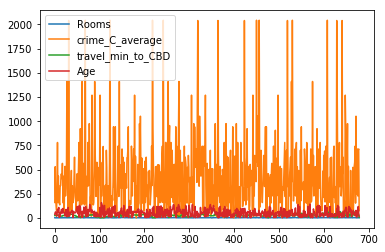

In [142]:
%matplotlib inline
temp_dataset["Rooms"].plot().legend(), temp_dataset["crime_C_average"].plot().legend(), temp_dataset["travel_min_to_CBD"].plot().legend(), temp_dataset["Age"].plot().legend()

(<matplotlib.legend.Legend at 0x1a25268dd8>,
 <matplotlib.legend.Legend at 0x1a25389a58>)

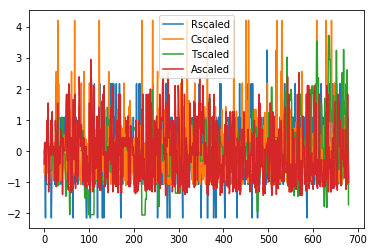

In [143]:
temp_dataset["Rscaled"].plot().legend(), temp_dataset["Cscaled"].plot().legend(), temp_dataset["Tscaled"].plot().legend(), temp_dataset["Ascaled"].plot().legend()

(<matplotlib.legend.Legend at 0x1a253963c8>,
 <matplotlib.legend.Legend at 0x1a23770e48>)

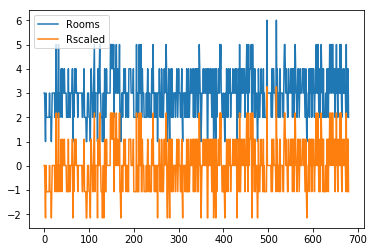

In [144]:
temp_dataset["Rooms"].plot().legend(), temp_dataset["Rscaled"].plot().legend()

(<matplotlib.legend.Legend at 0x1a238c2ba8>,
 <matplotlib.legend.Legend at 0x1a2385fb38>)

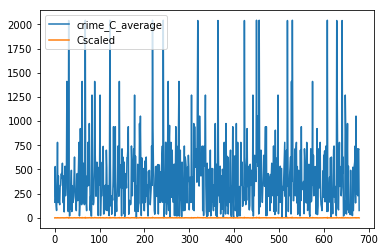

In [145]:
temp_dataset["crime_C_average"].plot().legend(), temp_dataset["Cscaled"].plot().legend()

(<matplotlib.legend.Legend at 0x1a238557b8>,
 <matplotlib.legend.Legend at 0x1a23b8e7b8>)

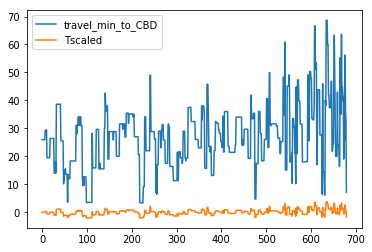

In [146]:
temp_dataset["travel_min_to_CBD"].plot().legend(), temp_dataset["Tscaled"].plot().legend()

(<matplotlib.legend.Legend at 0x1a23bb0748>,
 <matplotlib.legend.Legend at 0x1a2379fb70>)

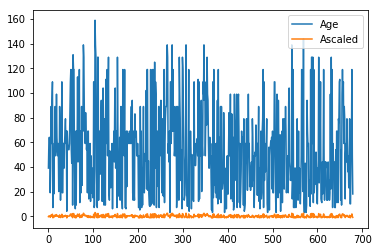

In [147]:
temp_dataset["Age"].plot().legend(), temp_dataset["Ascaled"].plot().legend()

#### MiniMax Normalization

In [148]:
minmax_scale = preprocessing.MinMaxScaler().fit(temp_dataset[['Rooms', 'crime_C_average', 'travel_min_to_CBD', 'Age']])
df_minmax = minmax_scale.transform(temp_dataset[['Rooms', 'crime_C_average', 'travel_min_to_CBD', 'Age']])
df_minmax[0:5]

/Users/nikitajohn/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([[0.4       , 0.07821685, 0.3456675 , 0.23076923],
       [0.4       , 0.25914435, 0.3456675 , 0.35897436],
       [0.2       , 0.10760941, 0.3456675 , 0.39102564],
       [0.        , 0.06237753, 0.3456675 , 0.35897436],
       [0.4       , 0.0365774 , 0.3456675 , 0.1025641 ]])

In [149]:
temp_dataset['Rminmax'] = df_minmax[:,0] 
temp_dataset['Cminmax'] = df_minmax[:,1]
temp_dataset['Tminmax'] = df_minmax[:,2]
temp_dataset['Aminmax'] = df_minmax[:,3]
temp_dataset.head()

,Price,Rooms,crime_C_average,travel_min_to_CBD,Age,Rscaled,Cscaled,Tscaled,Ascaled,Rminmax,Cminmax,Tminmax,Aminmax
0,1223500.0,3,160.666667,25.933333,39.0,0.015898,-0.693053,-0.056065,-0.410084,0.4,0.078217,0.345668,0.230769
1,962000.0,3,530.000000,25.933333,59.0,0.015898,0.271520,-0.056065,0.151392,0.4,0.259144,0.345668,0.358974
2,790000.0,2,220.666667,25.933333,64.0,-1.065157,-0.536353,-0.056065,0.291761,0.2,0.107609,0.345668,0.391026
3,405000.0,1,128.333333,25.933333,59.0,-2.146212,-0.777496,-0.056065,0.151392,0.0,0.062378,0.345668,0.358974
4,1850000.0,3,75.666667,25.933333,19.0,0.015898,-0.915044,-0.056065,-0.971559,0.4,0.036577,0.345668,0.102564


(<matplotlib.legend.Legend at 0x1a23e23e10>,
 <matplotlib.legend.Legend at 0x1a23e59f98>)

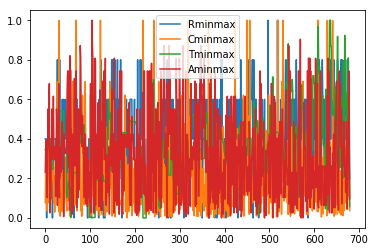

In [150]:
temp_dataset["Rminmax"].plot().legend(), temp_dataset["Cminmax"].plot().legend(), temp_dataset["Tminmax"].plot().legend(), temp_dataset["Aminmax"].plot().legend()

#### Conclusion from Normalization:

##### Rooms:

Rooms are categorical and only take discrete values between and including 0 and 6. Therefore, it doesn't need to be scaled. No normalization needs to be done to Rooms.

##### crime_C_average, travel_min_to_CBD, Age:

These attributes need to be scaled since the mean and variance seem to be very different for each. Each seems to have some outliers. The minimax method of normalization is very susceptible to outliers. Therefore, the Z score method of normalization is a better way to go. 

### Transformation

We want to see the effect on the dependent variable with a cange in the independent variables. Therefore, we plot each variable against price and see how a couple of transformation methods affect the relationship.

#### Crime_C_average:

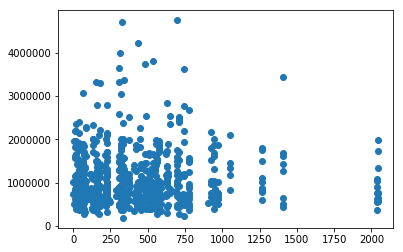

In [151]:
plt.scatter(temp_dataset["crime_C_average"], temp_dataset["Price"])

##### log

In [152]:
temp_dataset['tran_C'] = None
i = 0
for row in temp_dataset.iterrows():
    temp_dataset['tran_C'].at[i] = math.log(temp_dataset["crime_C_average"][i])
    i += 1

    
temp_dataset.head()

,Price,Rooms,crime_C_average,travel_min_to_CBD,Age,Rscaled,Cscaled,Tscaled,Ascaled,Rminmax,Cminmax,Tminmax,Aminmax,tran_C
0,1223500.0,3,160.666667,25.933333,39.0,0.015898,-0.693053,-0.056065,-0.410084,0.4,0.078217,0.345668,0.230769,5.07933
1,962000.0,3,530.000000,25.933333,59.0,0.015898,0.271520,-0.056065,0.151392,0.4,0.259144,0.345668,0.358974,6.27288
2,790000.0,2,220.666667,25.933333,64.0,-1.065157,-0.536353,-0.056065,0.291761,0.2,0.107609,0.345668,0.391026,5.39665
3,405000.0,1,128.333333,25.933333,59.0,-2.146212,-0.777496,-0.056065,0.151392,0.0,0.062378,0.345668,0.358974,4.85463
4,1850000.0,3,75.666667,25.933333,19.0,0.015898,-0.915044,-0.056065,-0.971559,0.4,0.036577,0.345668,0.102564,4.32634


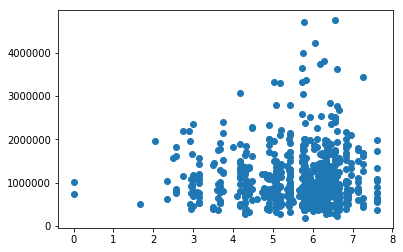

In [153]:
plt.scatter(temp_dataset["tran_C"], temp_dataset["Price"]) 

The log transformation seems to skew the data too much in the opposite direction.

##### sqrt

In [154]:
temp_dataset['tran_C'] = None
i = 0
for row in temp_dataset.iterrows():
    temp_dataset['tran_C'].at[i] = math.sqrt(temp_dataset["crime_C_average"][i])
    i += 1

    
temp_dataset.head()

,Price,Rooms,crime_C_average,travel_min_to_CBD,Age,Rscaled,Cscaled,Tscaled,Ascaled,Rminmax,Cminmax,Tminmax,Aminmax,tran_C
0,1223500.0,3,160.666667,25.933333,39.0,0.015898,-0.693053,-0.056065,-0.410084,0.4,0.078217,0.345668,0.230769,12.6754
1,962000.0,3,530.000000,25.933333,59.0,0.015898,0.271520,-0.056065,0.151392,0.4,0.259144,0.345668,0.358974,23.0217
2,790000.0,2,220.666667,25.933333,64.0,-1.065157,-0.536353,-0.056065,0.291761,0.2,0.107609,0.345668,0.391026,14.8549
3,405000.0,1,128.333333,25.933333,59.0,-2.146212,-0.777496,-0.056065,0.151392,0.0,0.062378,0.345668,0.358974,11.3284
4,1850000.0,3,75.666667,25.933333,19.0,0.015898,-0.915044,-0.056065,-0.971559,0.4,0.036577,0.345668,0.102564,8.69866


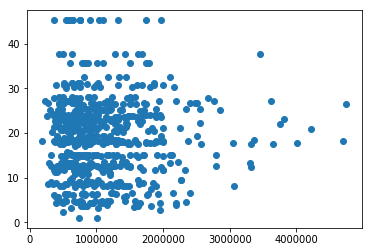

In [155]:
plt.scatter(temp_dataset["Price"], temp_dataset["tran_C"]) 

The square root transformation seems to make the data look relatively equally spread out. Therefore, it makes sense to use the square root transformation on crime_C_average when predicting for price.

#### travel_min_to_CBD

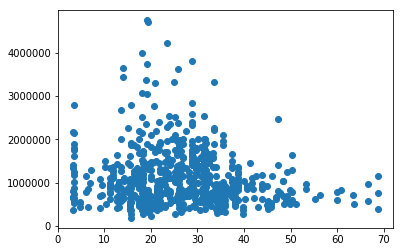

In [156]:
plt.scatter(temp_dataset["travel_min_to_CBD"], temp_dataset["Price"])

##### log

In [157]:
temp_dataset['tran_T'] = None
i = 0
for row in temp_dataset.iterrows():
    temp_dataset['tran_T'].at[i] = math.log(temp_dataset["travel_min_to_CBD"][i])
    i += 1

    
temp_dataset.head()

,Price,Rooms,crime_C_average,travel_min_to_CBD,Age,Rscaled,Cscaled,Tscaled,Ascaled,Rminmax,Cminmax,Tminmax,Aminmax,tran_C,tran_T
0,1223500.0,3,160.666667,25.933333,39.0,0.015898,-0.693053,-0.056065,-0.410084,0.4,0.078217,0.345668,0.230769,12.6754,3.25553
1,962000.0,3,530.000000,25.933333,59.0,0.015898,0.271520,-0.056065,0.151392,0.4,0.259144,0.345668,0.358974,23.0217,3.25553
2,790000.0,2,220.666667,25.933333,64.0,-1.065157,-0.536353,-0.056065,0.291761,0.2,0.107609,0.345668,0.391026,14.8549,3.25553
3,405000.0,1,128.333333,25.933333,59.0,-2.146212,-0.777496,-0.056065,0.151392,0.0,0.062378,0.345668,0.358974,11.3284,3.25553
4,1850000.0,3,75.666667,25.933333,19.0,0.015898,-0.915044,-0.056065,-0.971559,0.4,0.036577,0.345668,0.102564,8.69866,3.25553


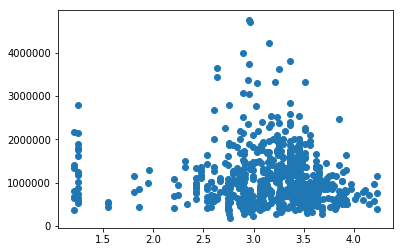

In [158]:
plt.scatter(temp_dataset["tran_T"], temp_dataset["Price"])

The log transformation skews in the opposite direction too much.

##### sqrt

In [159]:
temp_dataset['tran_T'] = None
i = 0
for row in temp_dataset.iterrows():
    temp_dataset['tran_T'].at[i] = math.sqrt(temp_dataset["travel_min_to_CBD"][i])
    i += 1

    
temp_dataset.head()

,Price,Rooms,crime_C_average,travel_min_to_CBD,Age,Rscaled,Cscaled,Tscaled,Ascaled,Rminmax,Cminmax,Tminmax,Aminmax,tran_C,tran_T
0,1223500.0,3,160.666667,25.933333,39.0,0.015898,-0.693053,-0.056065,-0.410084,0.4,0.078217,0.345668,0.230769,12.6754,5.09248
1,962000.0,3,530.000000,25.933333,59.0,0.015898,0.271520,-0.056065,0.151392,0.4,0.259144,0.345668,0.358974,23.0217,5.09248
2,790000.0,2,220.666667,25.933333,64.0,-1.065157,-0.536353,-0.056065,0.291761,0.2,0.107609,0.345668,0.391026,14.8549,5.09248
3,405000.0,1,128.333333,25.933333,59.0,-2.146212,-0.777496,-0.056065,0.151392,0.0,0.062378,0.345668,0.358974,11.3284,5.09248
4,1850000.0,3,75.666667,25.933333,19.0,0.015898,-0.915044,-0.056065,-0.971559,0.4,0.036577,0.345668,0.102564,8.69866,5.09248


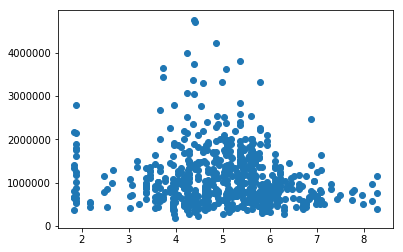

In [160]:
plt.scatter(temp_dataset["tran_T"], temp_dataset["Price"])

For travel_min_to_CBD, we could use the data without transformation, or we could use the square root transformation, which moves the data a little bit to the right. 

#### Age

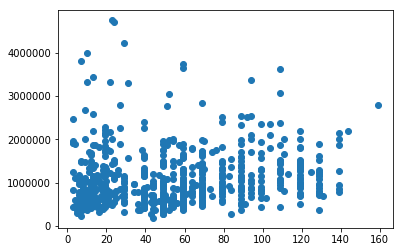

In [161]:
plt.scatter(temp_dataset["Age"], temp_dataset["Price"])

##### log

In [162]:
temp_dataset['tran_A'] = None
i = 0
for row in temp_dataset.iterrows():
    temp_dataset['tran_A'].at[i] = math.log(temp_dataset["Age"][i])
    i += 1

    
temp_dataset.head()

,Price,Rooms,crime_C_average,travel_min_to_CBD,Age,Rscaled,Cscaled,Tscaled,Ascaled,Rminmax,Cminmax,Tminmax,Aminmax,tran_C,tran_T,tran_A
0,1223500.0,3,160.666667,25.933333,39.0,0.015898,-0.693053,-0.056065,-0.410084,0.4,0.078217,0.345668,0.230769,12.6754,5.09248,3.66356
1,962000.0,3,530.000000,25.933333,59.0,0.015898,0.271520,-0.056065,0.151392,0.4,0.259144,0.345668,0.358974,23.0217,5.09248,4.07754
2,790000.0,2,220.666667,25.933333,64.0,-1.065157,-0.536353,-0.056065,0.291761,0.2,0.107609,0.345668,0.391026,14.8549,5.09248,4.15888
3,405000.0,1,128.333333,25.933333,59.0,-2.146212,-0.777496,-0.056065,0.151392,0.0,0.062378,0.345668,0.358974,11.3284,5.09248,4.07754
4,1850000.0,3,75.666667,25.933333,19.0,0.015898,-0.915044,-0.056065,-0.971559,0.4,0.036577,0.345668,0.102564,8.69866,5.09248,2.94444


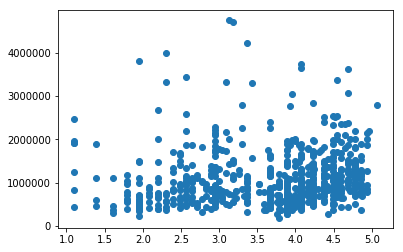

In [163]:
plt.scatter(temp_dataset["tran_A"], temp_dataset["Price"])

##### sqrt

In [164]:
temp_dataset['tran_A'] = None
i = 0
for row in temp_dataset.iterrows():
    temp_dataset['tran_A'].at[i] = math.sqrt(temp_dataset["Age"][i])
    i += 1

    
temp_dataset.head()

,Price,Rooms,crime_C_average,travel_min_to_CBD,Age,Rscaled,Cscaled,Tscaled,Ascaled,Rminmax,Cminmax,Tminmax,Aminmax,tran_C,tran_T,tran_A
0,1223500.0,3,160.666667,25.933333,39.0,0.015898,-0.693053,-0.056065,-0.410084,0.4,0.078217,0.345668,0.230769,12.6754,5.09248,6.245
1,962000.0,3,530.000000,25.933333,59.0,0.015898,0.271520,-0.056065,0.151392,0.4,0.259144,0.345668,0.358974,23.0217,5.09248,7.68115
2,790000.0,2,220.666667,25.933333,64.0,-1.065157,-0.536353,-0.056065,0.291761,0.2,0.107609,0.345668,0.391026,14.8549,5.09248,8
3,405000.0,1,128.333333,25.933333,59.0,-2.146212,-0.777496,-0.056065,0.151392,0.0,0.062378,0.345668,0.358974,11.3284,5.09248,7.68115
4,1850000.0,3,75.666667,25.933333,19.0,0.015898,-0.915044,-0.056065,-0.971559,0.4,0.036577,0.345668,0.102564,8.69866,5.09248,4.3589


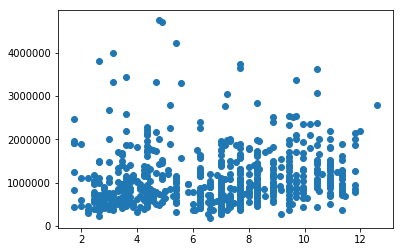

In [165]:
plt.scatter(temp_dataset["tran_A"], temp_dataset["Price"])

Similarly, for age, it makes sense to transform by square root.

#### Rooms

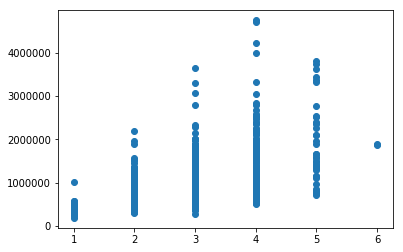

In [166]:
plt.scatter(temp_dataset["Rooms"], temp_dataset["Price"])

It doesn't make sense to do any transformation on Rooms, since the values here are discrete and categorical.

#### Conclusion from Transformation:

##### Rooms:

Rooms are categorical and only take discrete values between and including 0 and 6. Therefore, it doesn't make sense to do any transformation on this column.

#### crime_C_average, travel_min_to_CBD, Age:

These attributes seem to be right skewed. Therefore, on observing the above output, we can see that in most cases either no transformation or square root transformation can be used. 
It makes more sense to categorise each of these variables based on the rooms and see the effect and then determine what transformation to use.

## Conclusion

This assessment measured the understanding of parsing techniques, web scraping, and collating data using Python and helped us to understand the uses of the pandas, re and various other libraries. We were also able to improve our understanding of all the concepts discussed in the lectures and tutorials, since they were used extensively in this assignment. Apart from this, we were able to learn and understand the formats of xml, csv and html files.

The process of writing the program was long but thoroughly interesting. The code runs with no errors and gives the desired output. While working on this assignment we were able to implement concepts that were covered in the lectures and tutorials.

## References

- GeoPandas 0.6.0 — GeoPandas 0.6.0 documentation. (2019). Retrieved 27 October 2019, from http://geopandas.org/
- Chris Veness, w. (2019). Calculate distance and bearing between two Latitude/Longitude points using haversine formula in JavaScript. Retrieved 27 October 2019, from https://www.movable-type.co.uk/scripts/latlong.html
- Point in Polygon & Intersect — Intro to Python GIS documentation. (2019). Retrieved 27 October 2019, from https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html
- General Transit Feed Specification. (2019). Retrieved 27 October 2019, from https://en.wikipedia.org/wiki/General_Transit_Feed_Specification
- column, E., Kabra, P., & Kabra, P. (2019). Extracting just Month and Year separately from Pandas Datetime column. Retrieved 27 October 2019, from https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-separately-from-pandas-datetime-column